Convolutional autoencoder on Cifar10 dataset. This model is the best out of all the three

In [1]:
import numpy as np
import pickle
import os
import urllib
import tarfile
import zipfile
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [2]:
def _print_download_progress(count, block_size, total_size):
    """
    Helper function to visualize the download in progress
    Used as a call-back function
    """
    
    # percentage completion
    pct_complete = float(count * block_size) / total_size
    
    # Status message. \r means that the line should overwrite itself
    msg = "\r - Download progress : {0:.1%}".format(pct_complete)
    
    # print it
    sys.stdout.write(msg)
    sys.stdout.flush()

In [3]:
def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist
    """
    # Filename for saving the downloaded file
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)
    
    # Check if the file already exists. If it already exists then we assume it 
    # has already been extracted. Else we need to download and extract
    
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        
        # download the file from the internet
        file_path, _ = urllib.urlretrieve(url, file_path, _print_download_progress)
        
        print()
        print('Download finished. Extracting files.')
        
        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)
        print('Done.')
    else:
        print('Data has apparently already been downloaded and unpacked')

In [4]:
# Directory where you want to download and save the data-set
data_path = 'data_cifar10/'

# Url for the data-set on the internet
data_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# width and height of the image
img_size = 32

# number of channels in the image
num_channels = 3

# length of the image when flattened into a 1-d array
img_size_flat = img_size * img_size * num_channels

# number of classes
num_classes = 10

# number of files for the training set
_num_files_train = 5

# number of images for each batch-file in the training set
_images_per_file = 10000

# total number of images in the training set
_num_images_train = _num_files_train * _images_per_file

In [6]:
def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set
    """
    return os.path.join(data_path, "cifar-10-batches-py/", filename)

    
    
def _unpickle(filename):
    """
    Unpickle the given file and return its data
    """
    file_path = _get_file_path(filename)
    print("Loading data:" + file_path)
    
    with open(file_path, mode='rb') as file:
        data = pickle.load(file)
    
    return data


    
def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and 
    return a 4-dim array with shape : [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0
    """
    # Convert the raw images from the data-files to floating-points
    raw_float = np.array(raw, dtype=float) / 255.0
    
    # Reshape the array into 4-dim
    images = raw_float.reshape([-1, num_channels, img_size, img_size])
    
    # Reorder the indices of the array
    images = images.transpose([0, 2, 3, 1])
    
    return images



    
def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images
    """
    
    # Load the pickled data-file
    data = _unpickle(filename)
    
    # Get the raw images
    raw_images = data[b'data']
    
    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)
    
    return images, cls


def load_class_names():
    """
    Load the names for the classes in the CIFAR-10 data-set.
    Returns a list with the names. Example: names[3] is the name
    associated with class-number 3.
    """

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode("utf-8") for x in raw]

    return names


def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-hot encoded class-labels from an array of integers
    
    For example, if class_number=2 and num_classes=4 then the 
    one-hot encoded label is the float array: [0. 0. 1. 0.]
    """
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1
    
    return np.eye(num_classes, dtype=float)[class_numbers]
    
def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set
    The data-set is split into 5 data-files which are merged here
    Returns the images, class-numbers and one-hot encoded class-labels
    """
    
    # Pre-allocate the arrays for the images and class-numbers for efficiency
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)
    
    # Begin-index for the current batch
    begin = 0
    
    # For each data-file
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))
        
        # number of images in this batch
        num_images = len(images_batch)
        
        # end index of the current batch
        end = begin + num_images
        
        # Store the images into the array
        images[begin:end, :] = images_batch
        
        # Store the class-numbers into the array
        cls[begin:end] = cls_batch
        
        # the begin index for the next batch is the current end-index
        begin = end
        
    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    """
    Load all the test data for the dataset
    
    Returns the images, class-numbers and one-hot encoded class-labels
    """
    images, cls = _load_data(filename="test_batch")
    
    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

In [7]:
# Load the class-names
class_names = load_class_names()
class_names

Loading data:data_cifar10/cifar-10-batches-py/batches.meta


[u'airplane',
 u'automobile',
 u'bird',
 u'cat',
 u'deer',
 u'dog',
 u'frog',
 u'horse',
 u'ship',
 u'truck']

In [8]:
# Load the training-set.
# This returns the images, the class-numbers as integers, 
# and the class-numbers as One-Hot encoded arrays called labels

images_train, cls_train, labels_train = load_training_data()
images_train.shape

Loading data:data_cifar10/cifar-10-batches-py/data_batch_1
Loading data:data_cifar10/cifar-10-batches-py/data_batch_2
Loading data:data_cifar10/cifar-10-batches-py/data_batch_3
Loading data:data_cifar10/cifar-10-batches-py/data_batch_4
Loading data:data_cifar10/cifar-10-batches-py/data_batch_5


(50000, 32, 32, 3)

In [9]:
images_train.nbytes

1228800000

In [8]:
# Load the test set

images_test, cls_test, labels_test = load_test_data()

Loading data:data_cifar10/cifar-10-batches-py/test_batch


In [9]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [10]:
# images are 32x32 pixels but we will crop the images to 24x24 pixels
img_size_cropped = 24

In [11]:
# Helper function to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    
    assert len(images) == len(cls_true) == 9
    
    # create figure with sub-plots
    fig, axes = plt.subplots(3, 3)
    
    # adjust vertical spacing if we need to print ensemble and best-net
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Interpolation type
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        
        # Plot image
        ax.imshow(images[i, :, :, :], interpolation=interpolation)
        
        # Name of the true class
        cls_true_name = class_names[cls_true[i]]
        
        # Show the true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # name of the predicted class
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
        
        # show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        
        # remove the ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

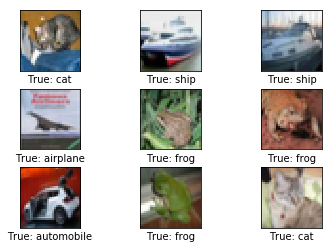

In [12]:
# Get the first images from the test-set
images = images_test[0:9]

# Get the true classes from those images
cls_true = cls_test[0:9]

# Plot the images and labels using the helper function
plot_images(images=images, cls_true=cls_true, smooth=False)

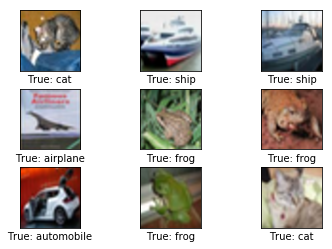

In [13]:
# the pixelated images above are what the neural net will get as an input. the images must be a bit easier for the
# human eye to recognize

plot_images(images=images, cls_true=cls_true, smooth=True)

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)
img_batch_size = tf.shape(x)[0]

In [15]:
def pre_process_image(image, training):
    # This function takes a single image as an input
    # and a boolean whether to build the training or testing graph
    
    if training:
        # For training, add the following to the tensor graph
        
        # randomly crop the input image
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        
        # Randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0., upper=2.)
        
        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
        
    else:
        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)
    return image

In [16]:
def pre_process(images, training):
    # Use TF to loop over all the input images and call
    # the function above which takes a single image as input
    
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    
    return images

In [17]:
# To plot the distorted images. Only graph is created. Executed later

distorted_images = pre_process(images=x, training=True)

In [18]:
# Create the model

def main_network(X, training=True, scope='dummy'):
    
    images = pre_process(X, training=training)
    print(images.shape)
    
    with tf.variable_scope(scope) as sc:
    
        # convolution 1
        wc1 = tf.get_variable('wc1', 
                              shape=(3, 3, 3, 32), 
                              initializer=tf.truncated_normal_initializer()) # weights
        conv1 = tf.nn.conv2d(images, wc1, strides=[1, 1, 1, 1], padding='SAME')
        bc1 = tf.get_variable('bc1', shape=(32,), initializer=tf.constant_initializer(0)) # biases
        conv1 = tf.nn.sigmoid(tf.add(conv1, bc1))
        # maxpooling
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        print(conv1.shape)
    
        # convolution 2
        wc2 = tf.get_variable('wc2', 
                              shape=(3, 3, 32, 64), 
                              initializer=tf.truncated_normal_initializer()) # weights
        conv2 = tf.nn.conv2d(conv1, wc2, strides=[1, 1, 1, 1], padding='SAME')
        bc2 = tf.get_variable('bc2', shape=(64,), initializer=tf.constant_initializer(0)) # biases
        conv2 = tf.nn.sigmoid(tf.add(conv2, bc2))
        # maxpooling
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        print(conv2.shape)
        
        # convolution 3
        wc3 = tf.get_variable('wc3', 
                              shape=(3, 3, 64, 64), 
                              initializer=tf.truncated_normal_initializer()) # weights
        conv3 = tf.nn.conv2d(conv2, wc3, strides=[1, 1, 1, 1], padding='SAME')
        bc3 = tf.get_variable('bc3', shape=(64,), initializer=tf.constant_initializer(0)) # biases
        conv3 = tf.nn.sigmoid(tf.add(conv3, bc3))
        # maxpooling
        conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        print(conv3.shape)
    
        # reshape the conv2 into a fully connected layer input
        wfc1 = tf.get_variable('wfc1', 
                               shape=(3*3*64, 400), 
                               initializer=tf.contrib.layers.xavier_initializer()) # weights
        bf1 = tf.get_variable('bf1', shape=(400,), initializer=tf.constant_initializer(0)) # biases
        fc1 = tf.reshape(conv3, shape=[-1, wfc1.get_shape().as_list()[0]])
    
        # fully connected layer 1
        fc1 = tf.nn.sigmoid(tf.add(tf.matmul(fc1, wfc1), bf1))
        print(fc1.shape)
    
        # fully connected layer 2 or the middle representation
        wfc2 = tf.get_variable('wfc2', 
                               shape=(400, 256), 
                               initializer=tf.contrib.layers.xavier_initializer()) # weights
        bf2 = tf.get_variable('bf2', shape=(256,), initializer=tf.constant_initializer(0)) # biases
        fc2 = tf.nn.sigmoid(tf.add(tf.matmul(fc1, wfc2), bf2))
        print(fc2.shape)
        
        encoded_output = fc2
        print('Input encoded!')
    
        # deconvolution fully connected layer 1
        wdf1 = tf.get_variable('wdf1', 
                               shape=(256, 400), 
                               initializer=tf.contrib.layers.xavier_initializer()) # weights
        bdf1 = tf.get_variable('bdf1', shape=(400,), initializer=tf.constant_initializer(0)) # biases
        dfc1 = tf.add(tf.matmul(encoded_output, wdf1), bdf1)
        dfc1 = tf.nn.sigmoid(dfc1)
        print(dfc1.shape)
        
        # deconvolution, fully connected layer 2
        wdf2 = tf.get_variable('wdf2',
                               shape=(400, 3*3*64),
                               initializer=tf.contrib.layers.xavier_initializer()) # weights
        bdf2 = tf.get_variable('bdf2', shape=(3*3*64,), initializer=tf.constant_initializer(0)) # biases
        dfc2 = tf.add(tf.matmul(dfc1, wdf2), bdf2)
        dfc2 = tf.nn.sigmoid(dfc2)
        
        # deconvolution 1
        wd1 = tf.get_variable('wd1', 
                              shape=(3, 3, 64, 64), 
                              initializer=tf.truncated_normal_initializer) # weights
        bd1 = tf.get_variable('bd1', shape=(64,), initializer=tf.constant_initializer(0)) # biases
        # reshape the output from the fully connected layer 2
        dfc2 = tf.reshape(dfc2, shape=[-1, 3, 3, 64])
        deconv1 = tf.nn.conv2d_transpose(dfc2, 
                                         wd1, 
                                         output_shape=[img_batch_size, 6, 6, 64], 
                                         strides=[1, 2, 2, 1], 
                                         padding='SAME')
        deconv1 = tf.nn.sigmoid(tf.add(deconv1, bd1))
        print(deconv1.shape)
        
        # deconvolution 2
        wd2 = tf.get_variable('wd2', 
                              shape=(3, 3, 32, 64), 
                              initializer=tf.truncated_normal_initializer) # weights
        bd2 = tf.get_variable('bd2', shape=(32,), initializer=tf.constant_initializer(0)) # biases
        deconv2 = tf.nn.conv2d_transpose(deconv1, 
                                         wd2, 
                                         output_shape=[img_batch_size, 12, 12, 32], 
                                         strides=[1, 2, 2, 1], 
                                         padding='SAME')
        deconv2 = tf.nn.sigmoid(tf.add(deconv2, bd2))
        print(deconv2.shape)
        
        # deconvolution 3
        wd3 = tf.get_variable('wd3', 
                              shape=(3, 3, 3, 32), 
                              initializer=tf.truncated_normal_initializer()) # weights
        bd3 = tf.get_variable('bd3', shape=(3,), initializer=tf.constant_initializer(0)) # biases
        deconv3 = tf.nn.conv2d_transpose(deconv2, 
                                         wd3, 
                                         output_shape=[img_batch_size, 24, 24, 3], 
                                         strides=[1, 2, 2, 1], 
                                         padding='SAME')
        deconv3 = tf.nn.sigmoid(tf.add(deconv3, bd3))
        print(deconv3.shape)
        
        decode = deconv3
    
        # calculate the loss
        loss = tf.reduce_mean(tf.square(decode - images))
    
    return decode, encoded_output, loss


In [19]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'
    
    with tf.variable_scope('network', reuse=not training):
        # rename the input placeholder
        images = x
        
        # create tf graph for pre-processing
        images = pre_process(images=images, training=training)
        
        # create tensorflow graph for the main processing
        decode, encode, loss = main_network(images, training)
    
    return decode, encode, loss

In [20]:
# Create a tf variable that keeps track of the number of optimization iterations performed so far

# trainable=False means tf will not optimize this variable
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

In [21]:
# create the nn used for training
_, _, loss = create_network(training=True)

# create an optimizer to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss, global_step=global_step)

# create the nn used for testing
decode, _, _ = create_network(training=False)

# create the nn used for getting the encoded output
_, encode, _ = create_network(training=False)

# saver object is used for storing and retrieving variables
saver = tf.train.Saver()

(?, 24, 24, 3)
(?, 12, 12, 32)
(?, 6, 6, 64)
(?, 3, 3, 64)
(?, 400)
(?, 256)
Input encoded!
(?, 400)
(?, ?, ?, 64)
(?, ?, ?, 32)
(?, ?, ?, 3)
(?, 24, 24, 3)
(?, 12, 12, 32)
(?, 6, 6, 64)
(?, 3, 3, 64)
(?, 400)
(?, 256)
Input encoded!
(?, 400)
(?, ?, ?, 64)
(?, ?, ?, 32)
(?, ?, ?, 3)
(?, 24, 24, 3)
(?, 12, 12, 32)
(?, 6, 6, 64)
(?, 3, 3, 64)
(?, 400)
(?, 256)
Input encoded!
(?, 400)
(?, ?, ?, 64)
(?, ?, ?, 32)
(?, ?, ?, 3)


In [22]:
train_batch_size = 64

def random_batch():
    """
    Function for creating a random batch of images from the training set
    """
    num_images = len(images_train)
    
    # creates a random index
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    # use the random index to select the images and their labels
    x_batch = images_train[idx, :, :, :]
    
    return x_batch

In [23]:
with tf.Session() as sess:
    
    num_iterations = 150000
    save_dir = 'checkpoint/cifar_10_conv_v3'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # this is the base filename for the checkpoints. TF will append iteration no etc
    save_path = os.path.join(save_dir, 'cifar_10_nn')
    
    try:
        print('Trying to print the last checkpoint...')
        
        # use tensorflow to find the latest checkpoint if any
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
        
        # try and load the data in the checkpoint
        saver.restore(sess, save_path=last_chk_path)
        
        # If we get to this point, the checkpoint was successfully loaded.
        print("Restored checkpoint from:", last_chk_path)
    except:
        # If the above failed for some reason, simply
        # initialize all the variables for the TensorFlow graph.
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())
    
    for i in range(num_iterations):
        x_batch = random_batch()
            
        # we would also want to retrieve the global step counter
        i_global, l, _ = sess.run([global_step, loss, optimizer], feed_dict={x: x_batch})
            
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # calculate batch accuracy
            c = sess.run(loss, feed_dict={x: x_batch})
            msg = "Global Step: {0:>6}, Batch Loss: {1:>6}"
            print(msg.format(i_global, c))
            #batch_acc = sess.run(accuracy, feed_dict={x: x_batch, y_true: y_batch})

            # Print status.
            #msg = "Global Step: {0:>6}, Loss: {1:>6}, Training Batch Accuracy: {2:>6.1%}"
            #print(msg.format(i_global, l, batch_acc))
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(sess,
                        save_path=save_path,
                        global_step=global_step)
            print("Saved checkpoint.")
    print('Optimization finished!')

Trying to print the last checkpoint...
INFO:tensorflow:Restoring parameters from None
Failed to restore checkpoint. Initializing variables instead.
Global Step:    100, Batch Loss: 0.107960119843
Global Step:    200, Batch Loss: 0.0524305589497
Global Step:    300, Batch Loss: 0.0280405078083
Global Step:    400, Batch Loss: 0.0201464276761
Global Step:    500, Batch Loss: 0.018203061074
Global Step:    600, Batch Loss: 0.0192963313311
Global Step:    700, Batch Loss: 0.0120012285188
Global Step:    800, Batch Loss: 0.0135493017733
Global Step:    900, Batch Loss: 0.0135403694585
Global Step:   1000, Batch Loss: 0.0127150127664
Saved checkpoint.
Global Step:   1100, Batch Loss: 0.0134359775111
Global Step:   1200, Batch Loss: 0.0111117614433
Global Step:   1300, Batch Loss: 0.010756386444
Global Step:   1400, Batch Loss: 0.00794765166938
Global Step:   1500, Batch Loss: 0.0106442626566
Global Step:   1600, Batch Loss: 0.00900919828564
Global Step:   1700, Batch Loss: 0.00768226198852
G

Global Step:  15800, Batch Loss: 0.00351693131961
Global Step:  15900, Batch Loss: 0.00410884805024
Global Step:  16000, Batch Loss: 0.00386733142659
Saved checkpoint.
Global Step:  16100, Batch Loss: 0.00457671657205
Global Step:  16200, Batch Loss: 0.00314639415592
Global Step:  16300, Batch Loss: 0.00348905031569
Global Step:  16400, Batch Loss: 0.00413750484586
Global Step:  16500, Batch Loss: 0.0046033654362
Global Step:  16600, Batch Loss: 0.00426293816417
Global Step:  16700, Batch Loss: 0.00392855610698
Global Step:  16800, Batch Loss: 0.0042825685814
Global Step:  16900, Batch Loss: 0.00420186342672
Global Step:  17000, Batch Loss: 0.00438616424799
Saved checkpoint.
Global Step:  17100, Batch Loss: 0.00505538657308
Global Step:  17200, Batch Loss: 0.00244099786505
Global Step:  17300, Batch Loss: 0.00566847342998
Global Step:  17400, Batch Loss: 0.00537052983418
Global Step:  17500, Batch Loss: 0.00352308060974
Global Step:  17600, Batch Loss: 0.00350585719571
Global Step:  17

Global Step:  31700, Batch Loss: 0.00280213612132
Global Step:  31800, Batch Loss: 0.0031609700527
Global Step:  31900, Batch Loss: 0.00370141468011
Global Step:  32000, Batch Loss: 0.00276693981141
Saved checkpoint.
Global Step:  32100, Batch Loss: 0.00365968584083
Global Step:  32200, Batch Loss: 0.00346133252606
Global Step:  32300, Batch Loss: 0.00244112429209
Global Step:  32400, Batch Loss: 0.00322865089402
Global Step:  32500, Batch Loss: 0.00288684014231
Global Step:  32600, Batch Loss: 0.00436476897448
Global Step:  32700, Batch Loss: 0.00355650275014
Global Step:  32800, Batch Loss: 0.00366816972382
Global Step:  32900, Batch Loss: 0.00345148937777
Global Step:  33000, Batch Loss: 0.00352568575181
Saved checkpoint.
Global Step:  33100, Batch Loss: 0.0036586378701
Global Step:  33200, Batch Loss: 0.00298610609025
Global Step:  33300, Batch Loss: 0.00363987591118
Global Step:  33400, Batch Loss: 0.00395460380241
Global Step:  33500, Batch Loss: 0.00329174986109
Global Step:  33

Global Step:  47600, Batch Loss: 0.00302269333042
Global Step:  47700, Batch Loss: 0.00288330717012
Global Step:  47800, Batch Loss: 0.00300904363394
Global Step:  47900, Batch Loss: 0.00258756289259
Global Step:  48000, Batch Loss: 0.00256534363143
Saved checkpoint.
Global Step:  48100, Batch Loss: 0.00283543439582
Global Step:  48200, Batch Loss: 0.00230689393356
Global Step:  48300, Batch Loss: 0.00287216692232
Global Step:  48400, Batch Loss: 0.00259151961654
Global Step:  48500, Batch Loss: 0.00305517925881
Global Step:  48600, Batch Loss: 0.00244908942841
Global Step:  48700, Batch Loss: 0.00331414910033
Global Step:  48800, Batch Loss: 0.00262295478024
Global Step:  48900, Batch Loss: 0.00351477274671
Global Step:  49000, Batch Loss: 0.00356356520206
Saved checkpoint.
Global Step:  49100, Batch Loss: 0.00293367705308
Global Step:  49200, Batch Loss: 0.00284018949606
Global Step:  49300, Batch Loss: 0.00261244946159
Global Step:  49400, Batch Loss: 0.00312784407288
Global Step:  

Global Step:  63500, Batch Loss: 0.00256875180639
Global Step:  63600, Batch Loss: 0.00207416340709
Global Step:  63700, Batch Loss: 0.00253913342021
Global Step:  63800, Batch Loss: 0.00292075518519
Global Step:  63900, Batch Loss: 0.00260995863937
Global Step:  64000, Batch Loss: 0.00294421473518
Saved checkpoint.
Global Step:  64100, Batch Loss: 0.00252273050137
Global Step:  64200, Batch Loss: 0.002940868726
Global Step:  64300, Batch Loss: 0.00231316429563
Global Step:  64400, Batch Loss: 0.00284547917545
Global Step:  64500, Batch Loss: 0.00212309928611
Global Step:  64600, Batch Loss: 0.00291155301966
Global Step:  64700, Batch Loss: 0.00253465143032
Global Step:  64800, Batch Loss: 0.00315457419492
Global Step:  64900, Batch Loss: 0.00221924344078
Global Step:  65000, Batch Loss: 0.00319205317646
Saved checkpoint.
Global Step:  65100, Batch Loss: 0.0021615838632
Global Step:  65200, Batch Loss: 0.00259665213525
Global Step:  65300, Batch Loss: 0.00233847601339
Global Step:  654

Global Step:  79400, Batch Loss: 0.00198260881007
Global Step:  79500, Batch Loss: 0.00213483325206
Global Step:  79600, Batch Loss: 0.00196454580873
Global Step:  79700, Batch Loss: 0.00237250654027
Global Step:  79800, Batch Loss: 0.00202762428671
Global Step:  79900, Batch Loss: 0.00322494818829
Global Step:  80000, Batch Loss: 0.00279624108225
Saved checkpoint.
Global Step:  80100, Batch Loss: 0.00229570828378
Global Step:  80200, Batch Loss: 0.00213069119491
Global Step:  80300, Batch Loss: 0.00227218400687
Global Step:  80400, Batch Loss: 0.00300530809909
Global Step:  80500, Batch Loss: 0.00208293180913
Global Step:  80600, Batch Loss: 0.00249369698577
Global Step:  80700, Batch Loss: 0.00245758681558
Global Step:  80800, Batch Loss: 0.00186324794777
Global Step:  80900, Batch Loss: 0.00261867674999
Global Step:  81000, Batch Loss: 0.00210119434632
Saved checkpoint.
Global Step:  81100, Batch Loss: 0.00285589648411
Global Step:  81200, Batch Loss: 0.00279330718331
Global Step:  

Global Step:  95300, Batch Loss: 0.00213463883847
Global Step:  95400, Batch Loss: 0.00217542005703
Global Step:  95500, Batch Loss: 0.00219799228944
Global Step:  95600, Batch Loss: 0.0022580747027
Global Step:  95700, Batch Loss: 0.00198153476231
Global Step:  95800, Batch Loss: 0.00285443267785
Global Step:  95900, Batch Loss: 0.00242485315539
Global Step:  96000, Batch Loss: 0.00246676662937
Saved checkpoint.
Global Step:  96100, Batch Loss: 0.00203753076494
Global Step:  96200, Batch Loss: 0.00251885410398
Global Step:  96300, Batch Loss: 0.00236877892166
Global Step:  96400, Batch Loss: 0.00206651980989
Global Step:  96500, Batch Loss: 0.00270157889463
Global Step:  96600, Batch Loss: 0.00234046159312
Global Step:  96700, Batch Loss: 0.00229381374083
Global Step:  96800, Batch Loss: 0.00209087855183
Global Step:  96900, Batch Loss: 0.00174037937541
Global Step:  97000, Batch Loss: 0.00244627334177
Saved checkpoint.
Global Step:  97100, Batch Loss: 0.00181179586798
Global Step:  9

Global Step: 111200, Batch Loss: 0.00192491046619
Global Step: 111300, Batch Loss: 0.0017857782077
Global Step: 111400, Batch Loss: 0.00211861752905
Global Step: 111500, Batch Loss: 0.00190185557585
Global Step: 111600, Batch Loss: 0.00240205833688
Global Step: 111700, Batch Loss: 0.00211110920645
Global Step: 111800, Batch Loss: 0.00205482915044
Global Step: 111900, Batch Loss: 0.0017221843591
Global Step: 112000, Batch Loss: 0.00204898137599
Saved checkpoint.
Global Step: 112100, Batch Loss: 0.00166572525632
Global Step: 112200, Batch Loss: 0.00197059195489
Global Step: 112300, Batch Loss: 0.00194233155344
Global Step: 112400, Batch Loss: 0.00219632103108
Global Step: 112500, Batch Loss: 0.0023194339592
Global Step: 112600, Batch Loss: 0.00207373406738
Global Step: 112700, Batch Loss: 0.00192687648814
Global Step: 112800, Batch Loss: 0.00172298506368
Global Step: 112900, Batch Loss: 0.00200720969588
Global Step: 113000, Batch Loss: 0.00223776744679
Saved checkpoint.
Global Step: 1131

Global Step: 127100, Batch Loss: 0.00168096658308
Global Step: 127200, Batch Loss: 0.00259729567915
Global Step: 127300, Batch Loss: 0.00237253424712
Global Step: 127400, Batch Loss: 0.00220282911323
Global Step: 127500, Batch Loss: 0.00208147033118
Global Step: 127600, Batch Loss: 0.00224732491188
Global Step: 127700, Batch Loss: 0.00239239353687
Global Step: 127800, Batch Loss: 0.00211059767753
Global Step: 127900, Batch Loss: 0.00213241274469
Global Step: 128000, Batch Loss: 0.00225046346895
Saved checkpoint.
Global Step: 128100, Batch Loss: 0.00212876754813
Global Step: 128200, Batch Loss: 0.00204698485322
Global Step: 128300, Batch Loss: 0.00190855504479
Global Step: 128400, Batch Loss: 0.0023119978141
Global Step: 128500, Batch Loss: 0.00215179449879
Global Step: 128600, Batch Loss: 0.00228753266856
Global Step: 128700, Batch Loss: 0.00207301811315
Global Step: 128800, Batch Loss: 0.00212774449028
Global Step: 128900, Batch Loss: 0.00202193157747
Global Step: 129000, Batch Loss: 

Global Step: 143000, Batch Loss: 0.00157001812477
Saved checkpoint.
Global Step: 143100, Batch Loss: 0.00169101345818
Global Step: 143200, Batch Loss: 0.00196015299298
Global Step: 143300, Batch Loss: 0.00170131179038
Global Step: 143400, Batch Loss: 0.00166899268515
Global Step: 143500, Batch Loss: 0.00190491590183
Global Step: 143600, Batch Loss: 0.00202754023485
Global Step: 143700, Batch Loss: 0.00193139829207
Global Step: 143800, Batch Loss: 0.00233673211187
Global Step: 143900, Batch Loss: 0.00208819913678
Global Step: 144000, Batch Loss: 0.00208057905547
Saved checkpoint.
Global Step: 144100, Batch Loss: 0.00176460517105
Global Step: 144200, Batch Loss: 0.00198950222693
Global Step: 144300, Batch Loss: 0.00170952302869
Global Step: 144400, Batch Loss: 0.00225512892939
Global Step: 144500, Batch Loss: 0.00158799334895
Global Step: 144600, Batch Loss: 0.00245459936559
Global Step: 144700, Batch Loss: 0.00161045545246
Global Step: 144800, Batch Loss: 0.00176481704693
Global Step: 1

In [23]:
test_batch_size = 5

def random_test_batch():
    """
    Function for creating a random batch of images from the test set
    """
    num_images = len(images_test)
    
    # creates a random index
    idx = np.random.choice(num_images,
                           size=test_batch_size,
                           replace=True)
    # use the random index to select the images and their labels
    x_batch = images_test[idx, :, :, :]
    y_test_cls = cls_test[idx,]
    
    return x_batch, y_test_cls

INFO:tensorflow:Restoring parameters from checkpoint/cifar_10_conv_v3/cifar_10_nn-150000
Model restored.


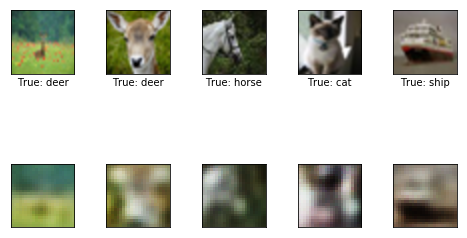

In [24]:
x_test_batch, y_test_cls = random_test_batch()
with tf.Session() as sess:
    saver.restore(sess, "checkpoint/cifar_10_conv_v3/cifar_10_nn-150000")
    print("Model restored.")
    
    encode_decode = sess.run(decode, feed_dict={x: x_test_batch})
    
# create figure with sub-plots
fig, ax = plt.subplots(2, 5, figsize=(8,5))

# adjusting spacing between images
fig.subplots_adjust(hspace=0.3, wspace=0.5)

for i in range(test_batch_size):
    
    # plot the input image
    ax[0][i].imshow(x_test_batch[i, :, :, :], interpolation='spline16')
    # Name of the true class
    cls_true_name = class_names[y_test_cls[i]]
    # Show the true class
    xlabel = "True: {0}".format(cls_true_name)
    # show the classes as the label on the x-axis
    ax[0][i].set_xlabel(xlabel)
    # remove the ticks from the plot
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    
    # plot the reconstructed image
    ax[1][i].imshow(encode_decode[i, :, :, :])
    # remove the ticks from the plot
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    
plt.draw()
plt.show()

In [25]:
latent_train_images = np.zeros(shape=(len(images_train), 256))
with tf.Session() as sess:
    
    saver.restore(sess, "checkpoint/cifar_10_conv_v3/cifar_10_nn-150000")
    print("Model restored.")
    
    num_images = len(images_train)
    # begin index of the next block of images
    i = 0
    batch_size = 100
    while i < num_images:
    
        # end index of the next batch
        j = min(i + batch_size, num_images)
    
        encoded_output = sess.run(encode, feed_dict={x: images_train[i:j, :]})
        
        
        latent_train_images[i:j, :] = encoded_output
        
        # set the start index of the next batch as the end index of this batch
        i = j

INFO:tensorflow:Restoring parameters from checkpoint/cifar_10_conv_v3/cifar_10_nn-150000
Model restored.


In [26]:
latent_train_images.shape

(50000, 256)

In [27]:
def eucledianDistance(instance1, instance2):
    return np.sqrt(np.sum(np.power((instance1 - instance2), 2)))

In [90]:
import operator
k = 5
test_input_index = np.random.randint(0, len(images_test) - 1)
test_feed_dict = images_test[test_input_index:(test_input_index + 1),:]

with tf.Session() as sess:
    saver.restore(sess, "checkpoint/cifar_10_conv_v3/cifar_10_nn-150000")
    print("Model restored.")
    
    encoded_test_instance = sess.run(encode, feed_dict={x: test_feed_dict})
    
distances = []
for i in range(len(images_train)):
    dist = eucledianDistance(latent_train_images[i, :], encoded_test_instance)
    distances.append((images_train[i,:], cls_train[i], dist))

distances.sort(key=operator.itemgetter(2))
neighbours = []
for j in range(k):
    neighbours.append((distances[j][0], distances[j][1]))

INFO:tensorflow:Restoring parameters from checkpoint/cifar_10_conv_v3/cifar_10_nn-150000
Model restored.


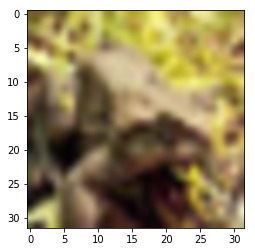

True: frog


In [91]:
img = images_test[test_input_index, :]
imgplot = plt.imshow(img, interpolation='spline16')
cls_true_name = class_names[cls_test[test_input_index]]
xlabel = "True: {0}".format(cls_true_name)
plt.draw()
plt.show()
print(xlabel)

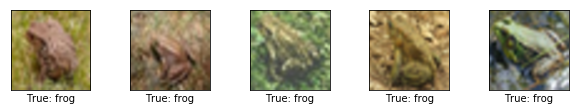

In [92]:
# create figure with sub-plots
fig, ax = plt.subplots(1, k, figsize=(10,5), squeeze=False)

# adjusting spacing between images
fig.subplots_adjust(hspace=0.3, wspace=0.5)

for i in range(k):
    
    # plot the input image
    ax[0][i].imshow(neighbours[i][0], interpolation='spline16')
    # Name of the true class
    cls_true_name = class_names[neighbours[i][1]]
    # Show the true class
    xlabel = "True: {0}".format(cls_true_name)
    # show the classes as the label on the x-axis
    ax[0][i].set_xlabel(xlabel)
    # remove the ticks from the plot
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    
plt.draw()
plt.show()

In [153]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = np.array([[1.5],[3.4],[0.9]])
d = []
for i in range(3):
    d.append((a[i], b[i]))
d.sort(key=operator.itemgetter(1))
d

[(array([7, 8, 9]), array([ 0.9])),
 (array([1, 2, 3]), array([ 1.5])),
 (array([4, 5, 6]), array([ 3.4]))]